import libraries

In [1]:
# Load Python packages
import import_ipynb
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, auc
from rpy2 import robjects
from rpy2.robjects.packages import importr
from utils import *

# Load R & packages
%load_ext rpy2.ipython
%R suppressMessages(library(textmineR))
%R suppressMessages(library(FEAST))
%R suppressMessages(library(doParallel))
%R suppressMessages(library(foreach))

# Basic configuration for pyplot & numpy
plt.style.use(['science','no-latex'])
np.random.seed(1)

importing Jupyter notebook from utils.ipynb


load datasets

In [2]:
datasets = load_datasets()

In [3]:
def make_meta(otus_with_status):
    sources_ix = np.random.rand(1352) < 0.9
    sinks_ix = ~sources_ix
    meta = pd.DataFrame(data={'Env': otus_with_status['Status'].tolist(), 
                              'SourceSink': 'Source'}, 
                        index=otus_with_status['SampleID'])
    meta.loc[sinks_ix, 'SourceSink'] = 'Sink'
    meta['id'] = 1
    meta.loc[meta['SourceSink'] == 'Sink', 'id'] = list(range(1, sum(sinks_ix) + 1))
    return meta

# Generate meta table using information from '3F' table, save to ../Tmp/...
meta = make_meta(datasets['3F'].copy())
meta.to_csv('../Tmp/meta.csv')

# Transform raw otus table to FEAST & JSD-acceptable otus
otus = to_otus(datasets)
a_101f = otus['整数-101F'].fillna(0).astype(int)
b_3f = otus['3F'].fillna(0).astype(int)
c_top5f = otus['top5F'].fillna(0).astype(int)
d_top3f = otus['top3F'].fillna(0).astype(int)

do sourcetracking

In [6]:
%%time
%%R -i meta -i a_101f -i b_3f -i c_top5f -i d_top3f

# Just keep sink rows and source columns
ids.sources <- rownames(meta[meta$SourceSink == 'Source', ]) 
ids.sinks <- rownames(meta[meta$SourceSink == 'Sink', ])

# Prepare for iteration over datasets
multi_otus <- list(F5_top=c_top5f, F3_top=d_top3f, F101=a_101f, F3=b_3f)
names <- c("F5_top", "F3_top", "F101", "F3")
registerDoParallel(makeCluster(4))

# Iteration
foreach(i=1:length(multi_otus), .packages=c('FEAST','textmineR')) %dopar% {
    otus <- as.matrix(multi_otus[[i]])#[1:50, ]
    otus <- otus[rowSums(otus) > 0, ]
    
    # Calculating source proportions and save to ../Tmp/...
    FEAST(C = otus, metadata = meta, different_sources_flag = 0, #EM_iterations=10, 
      COVERAGE = 1000, dir_path = "../Tmp/", outfile=names[i])
    
    # Calculating JSD matrix and save to ../Tmp/...
    dis.ma <- CalcJSDivergence(x=as.matrix(multi_otus[[i]]))[ids.sinks, ids.sources]
    write.csv(dis.ma, paste0('../Tmp/', names[i], '.jsd.distance.csv'), 
              row.names=T, col.names=T)
}
stopImplicitCluster()

CPU times: user 891 ms, sys: 359 ms, total: 1.25 s
Wall time: 18.1 s


evaluation

In [50]:
# Prepare
names = ["F5_top", "F3_top", "F101", "F3"]
meta = pd.read_csv('../tmp/meta.csv')
res_JSD = {name: '../Tmp/'+name+'.jsd.distance.csv' for name in names}
res_FEAST = {name: '../Tmp/'+name+'_source_contributions_matrix.txt' for name in names}
pred_JSD = {name: '../DLMER-Bio/'+name+'.JSD.predictions.csv' for name in names}
pred_FEAST = {name: '../DLMER-Bio/'+name+'.FEAST.predictions.csv' for name in names}
DLMER_in_JSD = {name: '../DLMER-Bio/'+name+'.JSD.DLMER.in.txt' for name in names}
DLMER_in_FEAST = {name: '../DLMER-Bio/'+name+'.FEAST.DLMER.in.txt' for name in names}
metrics_JSD = {name: '../DLMER-Bio/metrics.'+name+'.JSD.csv' for name in names}
metrics_FEAST = {name: '../DLMER-Bio/metrics.'+name+'.FEAST.csv' for name in names}

# Read res
res_JSD_dfs = {name: pd.read_csv(f, index_col=0) for name, f in res_JSD.items()}
res_FEAST_dfs = {name: pd.read_csv(f, sep='\t') for name, f in res_FEAST.items()}

In [6]:
# Post processing
pred_JSD_dfs = {name: JSD_post_proc(df, meta) for name, df in res_JSD_dfs.items()}
pred_FEAST_dfs = {name: FEAST_post_proc(df) for name, df in res_FEAST_dfs.items()}

# Write pred to disk
tmp = [ [pred_JSD_dfs[name].to_csv(pred_JSD[name]), 
         pred_FEAST_dfs[name].to_csv(pred_FEAST[name])] for name in names ]

In [24]:
# To DLMER-Bio format and calculate metrics using DLMER-Bio
for name in tqdm(names):
    os.system('todlmer -i {} -o {} -ixID SampleID -ixY Env'.format(pred_JSD[name], DLMER_in_JSD[name]))
    os.system('todlmer -i {} -o {} -ixID SampleID -ixY Env'.format(pred_FEAST[name], DLMER_in_FEAST[name]))
    os.system('dlmer -i {} -o {}'.format(DLMER_in_JSD[name], metrics_JSD[name]))
    os.system('dlmer -i {} -o {}'.format(DLMER_in_FEAST[name], metrics_FEAST[name]))

100%|██████████| 4/4 [00:18<00:00,  4.69s/it]


In [56]:
# Read metrics
metrics_FEAST_new = {'FEAST.'+name: pd.read_csv(f) for name, f in metrics_FEAST.items()}
metrics_JSD_new = {'JSD.'+name: pd.read_csv(f) for name, f in metrics_JSD.items()}
metrics = {name: df for name, df in {**metrics_FEAST_new, **metrics_JSD_new}.items()}
metrics_survived = {name: df[df['label'] == 'survived'].reset_index(drop=True) 
                    for name, df in metrics.items()}
metrics_died = {name: df[df['label'] == 'died'].reset_index(drop=True) 
                for name, df in metrics.items()}

met_svvd_jsd = {name: df for name, df in metrics_survived.items() if name.startswith('JSD')}
met_svvd_feast = {name: df for name, df in metrics_survived.items() if name.startswith('FEAST')}
met_died_jsd = {name: df for name, df in metrics_died.items() if name.startswith('JSD')}
met_died_feast = {name: df for name, df in metrics_died.items() if name.startswith('FEAST')}

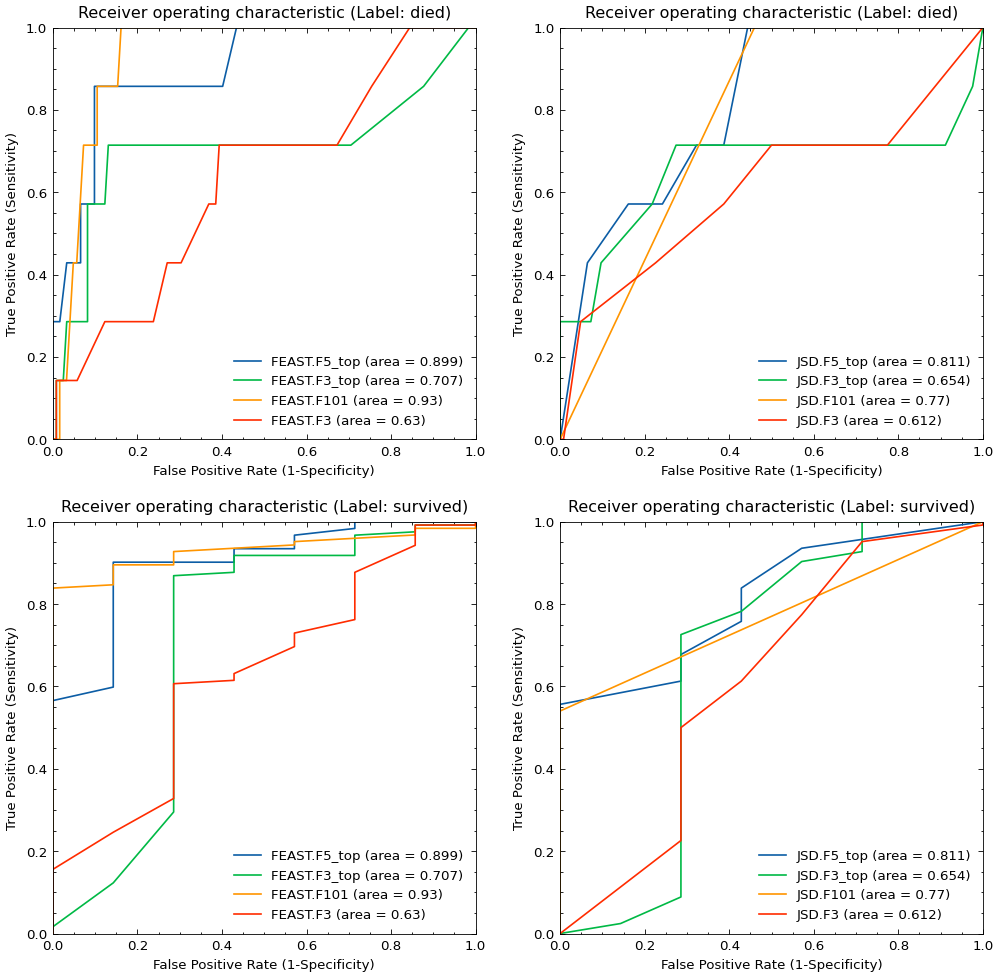

In [69]:
def plot_ROC(dfs, ax, title_suffix):
	for name, df in dfs.items():
		Fpr = df['FPR']
		Tpr = df['TPR']
		roc_auc = auc(Fpr, Tpr)
		ax.plot(Fpr, Tpr, label='{} (area = {:.3})'.format(name, roc_auc))
	ax.plot([0, 0], [1, 1], lw=0.6, linestyle='--')
	ax.set_xlim([0,1])
	ax.set_ylim([0,1])
	ax.set_xlabel('False Positive Rate (1-Specificity)')
	ax.set_ylabel('True Positive Rate (Sensitivity)')
	ax.set_title('Receiver operating characteristic ({})'.format(title_suffix))
	ax.legend(loc="lower right", fontsize=8)

plt.style.use(['science','no-latex'])
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10), dpi=120)
#figure.suptitle('Performance across Datasets & Methods', fontsize=16)
plot_ROC(met_died_feast, ax1, title_suffix='Label: died')
plot_ROC(met_died_jsd, ax2, title_suffix='Label: died')
plot_ROC(met_svvd_feast, ax3, title_suffix='Label: survived')
plot_ROC(met_svvd_jsd, ax4, title_suffix='Label: survived')
plt.savefig('../figs.pdf', format='pdf')
plt.show()
# Plot ROC curve
#...